In [ ]:

import ee
ee.Authenticate()



MessageError: Error: credential propagation was unsuccessful

In [ ]:
ee.Initialize(project= 'liutaogee')


In [ ]:
import geemap
Map=geemap.Map()
Map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In [ ]:
# 定义感兴趣区域的 FeatureCollection
aoi = ee.FeatureCollection('projects/liutaogee/assets/WeiheRiverBasinpoly').geometry().bounds()

# 创建一个空白图像
empty = ee.Image().byte()

# 为感兴趣区域绘制轮廓
outline = empty.paint(
  featureCollection=aoi,
  color=0,
  width=3
)

# 在地图上添加轮廓图层
Map.addLayer(outline, {'palette': 'ff0000'}, 'outline')
Map

Map(bottom=812.0, center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=Search…

In [ ]:
# 定义函数：用于遮蔽 Sentinel-2 中的云
def maskS2clouds(image):
    qa = image.select('QA60')

    # Bits 10 and 11 represent clouds and cirrus, respectively.
    cloudBitMask = 1 << 10
    cirrusBitMask = 1 << 11

    # 云和卷积云标志位的值应都为0，表示无云覆盖。
    mask = qa.bitwiseAnd(cloudBitMask).eq(0) \
        .And(qa.bitwiseAnd(cirrusBitMask).eq(0))

    return image.updateMask(mask).divide(10000)

# 构建 Sentinel-2 影像集，按日期、范围和云覆盖百分比进行筛选
dataset = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED') \
              .filterDate('2022-01-01','2022-12-31') \
              .filterBounds(aoi) \
              .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10)) \
              .map(maskS2clouds)
# 对每个影像应用 maskS2clouds 函数，并设置 tileScale 参数
#dataset = dataset.map(lambda image: image.set('tileScale', 8).clip(aoi).mask(maskS2clouds(image)))


#print("Sentinel 2 Image Collection", dataset)
label_img = dataset.median() # 中值影像，裁剪出研究区影像
#Map.addLayer(label_img, {'bands': ["B4", "B3", "B2"], 'min': 0, 'max': 0.3}, 'labellayer')

# 设置地图中心位置并显示地图

#Map

In [ ]:
# Define the function to add remote sensing indices
def add_RS_index(image):
    rvi = image.expression('NIR / RED', {
        'NIR': image.select('B8'),
        'RED': image.select('B4')
    }).float().rename('RVI').copyProperties(image, ['system:time_start'])

    evi = image.expression('2.5 * ((NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1))', {
        'NIR': image.select('B8'),
        'RED': image.select('B4'),
        'BLUE': image.select('B2')
    }).float().rename('EVI').copyProperties(image, ['system:time_start'])
    dvi = image.expression('NIR - RED', {
    'NIR' : image.select('B8'),
    'RED' : image.select('B4')
    }).float().rename('DVI').copyProperties(image,['system:time_start']);
    ndvi = image.normalizedDifference(['B8', 'B4']).rename("NDVI").copyProperties(image,['system:time_start']);
    savi = image.expression('(NIR - RED) * (1 + 0.5)/(NIR + RED + 0.5)', {
    'NIR': image.select('B8'),
    'RED': image.select('B4')
    }).float().rename('SAVI').copyProperties(image,['system:time_start']);
    gcvi = image.expression('NIR / Green - 1', {
    'NIR' : image.select('B8'),
    'Green' : image.select('B3')
    }).float().rename('GCVI').copyProperties(image,['system:time_start']);
    mndwi = image.addBands(image.normalizedDifference(['B3', 'B11']).rename("MNDWI").copyProperties(image,['system:time_start']));
    ndwi = image.addBands(image.normalizedDifference(['B3', 'B8']).rename("NDWI").copyProperties(image,['system:time_start']));
    ndbi = image.addBands(image.normalizedDifference(['B11', 'B8']).rename("NDBI").copyProperties(image,['system:time_start']));
    # Add other index calculations here
    return image.addBands([rvi,dvi,ndvi,mndwi,gcvi,savi,ndbi,ndwi,evi])
data1 = dataset.map(add_RS_index).median()





In [ ]:
data2 = dataset.map(add_RS_index).max()
data2 = data2.select(['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12','NDVI','GCVI','SAVI','EVI','NDWI','NDBI','MNDWI', 'RVI', 'DVI'],['B22','B23','B24','B25','B26','B27','B28','B28A','B211','B212','NDVI2','GCVI2','SAVI2','EVI2','NDWI2','NDBI2','MNDWI2','RVI2','DVI2',])

In [ ]:
data3 = dataset.map(add_RS_index).min()
data3 = data3.select(['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12','NDVI','GCVI','SAVI','EVI','NDWI','NDBI','MNDWI', 'RVI', 'DVI'],['B32','B33','B34','B35','B36','B37','B38','B38A','B311','B312','NDVI3','GCVI3','SAVI3','EVI3','NDWI3','NDBI3','MNDWI3','RVI3','DVI3'])



In [ ]:
data4 = dataset.map(add_RS_index).reduce(ee.Reducer.mode())
data4 = data4.select(['B2_mode', 'B3_mode', 'B4_mode', 'B5_mode', 'B6_mode', 'B7_mode', 'B8A_mode', 'B9_mode', 'B11_mode', 'B12_mode','NDVI_mode','GCVI_mode','SAVI_mode','EVI_mode','NDWI_mode','NDBI_mode','MNDWI_mode','RVI_mode','DVI_mode'],['B42','B43','B44','B45','B46','B47','B48','B48A','B411','B412','NDVI4','GCVI4','SAVI4','EVI4','NDWI4','NDBI4','MNDWI4','RVI4','DVI4'])


In [ ]:
data5 = dataset.map(add_RS_index).reduce(ee.Reducer.stdDev())
data5 = data5.select(['B2_stdDev', 'B3_stdDev', 'B4_stdDev', 'B5_stdDev', 'B6_stdDev', 'B7_stdDev', 'B8_stdDev', 'B8A_stdDev', 'B11_stdDev', 'B12_stdDev','NDVI_stdDev','GCVI_stdDev','SAVI_stdDev','EVI_stdDev','NDWI_stdDev','NDBI_stdDev','MNDWI_stdDev', 'RVI_stdDev', 'DVI_stdDev'],['B52','B53','B54','B55','B56','B57','B58','B58A','B511','B512','NDVI5','GCVI5','SAVI5','EVI5','NDWI5','NDBI5','MNDWI5','RVI5','DVI5'] )

In [ ]:
data6 = dataset.map(add_RS_index).reduce(ee.Reducer.mean())
data6 = data6.select(['B2_mean', 'B3_mean', 'B4_mean', 'B5_mean', 'B6_mean', 'B7_mean', 'B8A_mean', 'B9_mean', 'B11_mean', 'B12_mean','NDVI_mean','GCVI_mean','SAVI_mean','EVI_mean','NDWI_mean','NDBI_mean','MNDWI_mean','RVI_mean','DVI_mean'],['B62','B63','B64','B65','B66','B67','B68','B68A','B611','B612','NDVI6','GCVI6','SAVI6','EVI6','NDWI6','NDBI6','MNDWI6','RVI6','DVI6'])

In [ ]:
print(data4.bandNames().getInfo())

['B42', 'B43', 'B44', 'B45', 'B46', 'B47', 'B48', 'B48A', 'B411', 'B412', 'NDVI4', 'GCVI4', 'SAVI4', 'EVI4', 'NDWI4', 'NDBI4', 'MNDWI4', 'RVI4', 'DVI4']


In [ ]:
gray = label_img.expression(
    '(0.3 * NIR) + (0.59 * R) + (0.11 * G)', {
        'NIR': label_img.select('B5'),
        'R': label_img.select('B4'),
        'G': label_img.select('B3'),
    }).rename('gray')

glcm = gray.unitScale(0, 0.30).multiply(100).toInt().glcmTexture(1)

data = data1.addBands(glcm)

# Select bands for the final image collection
bands = ['B2','B3','B4','B5','B6','B7','B8','B8A','B11','B12']
bands0000 = ['NDVI','GCVI','SAVI','EVI','NDWI','NDBI','MNDWI','RVI','DVI']
bands000 = ['gray_asm','gray_corr','gray_contrast','gray_var',]
bands00 = ['gray_idm','gray_savg','gray_svar','gray_sent']
bands0= ['gray_ent','gray_dvar','gray_dent','gray_imcorr1','gray_imcorr2','gray_maxcorr','gray_diss','gray_inertia','gray_shade','gray_prom']
bands2 = ['NDVI2','GCVI2','SAVI2','EVI2','NDWI2','NDBI2','MNDWI2','RVI2','DVI2',]
bands3 = ['NDVI3','GCVI3','SAVI3','EVI3','NDWI3','NDBI3','MNDWI3','RVI3','DVI3']
bands4 = ['NDVI4','GCVI4','SAVI4','EVI4','NDWI4','NDBI4','MNDWI4','RVI4','DVI4']
bands5 = ['NDVI5','GCVI5','SAVI5','EVI5','NDWI5','NDBI5','MNDWI5','RVI5','DVI5']
bands6 = ['NDVI6','GCVI6','SAVI6','EVI6','NDWI6','NDBI6','MNDWI6','RVI6','DVI6']
imgcol_median = data.select(bands)
imgcol_median1 = data.select(bands0000)
imgcol_median2 = data.select(bands000)
imgcol_median3 = data.select(bands00)
imgcol_median4 = data.select(bands0)
max1 = data2.select(bands2)
min1 = data3.select(bands3)
percent25  = data4.select(bands4)
std1 = data5.select(bands5)
percent75 = data6.select(bands6)
# Load a Digital Elevation Model (DEM) image
dem = ee.Image("NASA/NASADEM_HGT/001").clip(aoi)
terrain = ee.Algorithms.Terrain(dem)

elevation = terrain.select('elevation')

slope = terrain.select('slope')

aspect = terrain.select('aspect')
construct_img = imgcol_median.addBands(imgcol_median1).addBands(imgcol_median2).addBands(imgcol_median3).addBands(imgcol_median4).addBands(max1).addBands(min1).addBands(percent25).addBands(percent75).addBands(std1).addBands(elevation).addBands(slope).addBands(aspect)
lon_lat = ee.Image.pixelLonLat()

# 分别提取经度和纬度波段
lon = lon_lat.select('longitude')
lat = lon_lat.select('latitude')

# 把经度和纬度的波段添加到输入图像中
construct_img = construct_img.addBands(lon.rename('longitude')).addBands(lat.rename('latitude'))
# Sample regions for training data
points = ee.FeatureCollection('users/liul44637/2points')
label = 'landcover'
#bands = construct_img.bandNames()
#bands0 = ['longitude','latitude','DEM','B1','B2','B3','B4','B5','B6','B7','B8','B8A','B9','B12','AOT','WVP','SCL','B11','S2_NDVI_B84','GCVI','REP','SAVI','EVI','IBI','NIRV','CIR','CIG','MTCI','S2_NDWI','S2_NDBI','S2_MNDWI','RVI','DVI','S2_LSWI_B811','S2_LSWI_B812','S2_LSWI_B8A11','S2_LSWI_B8A12','gray_asm','gray_corr','gray_contrast','gray_var','gray_idm','gray_savg','gray_svar','gray_sent']



In [ ]:
# 加载 Sentinel-1 数据集
sentinel1 = ee.ImageCollection('COPERNICUS/S1_GRD') \
            .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV')) \
            .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH')) \
            .filter(ee.Filter.eq('instrumentMode', 'IW')) \
            .filterBounds(aoi)
# 设置分辨率为10米
scale = 30
# 获取不同观测角下的极化数据
vvAscending = sentinel1.filter(ee.Filter.eq('orbitProperties_pass', 'ASCENDING')).select('VV')
#vvDescending = sentinel1.filter(ee.Filter.eq('orbitProperties_pass', 'DESCENDING')).select('VV')
vhAscending = sentinel1.filter(ee.Filter.eq('orbitProperties_pass', 'ASCENDING')).select('VH')
#vhDescending = sentinel1.filter(ee.Filter.eq('orbitProperties_pass', 'DESCENDING')).select('VH')

# 筛选时间设定
spring = ee.Filter.date('2020-01-01', '2020-12-31')

# 计算VV和VH极化数据的均值
vvAscending_mean = vvAscending.filter(spring).reduce(ee.Reducer.mean()).reproject(crs='EPSG:4326', scale=scale)
#vvDescending_mean = vvDescending.filter(spring).reduce(ee.Reducer.mean()).reproject(crs='EPSG:4326', scale=scale)
vhAscending_mean = vhAscending.filter(spring).reduce(ee.Reducer.mean()).reproject(crs='EPSG:4326', scale=scale)
#vhDescending_mean = vhDescending.filter(spring).reduce(ee.Reducer.mean()).reproject(crs='EPSG:4326', scale=scale)
construct_img = construct_img.addBands(vvAscending_mean).addBands(vhAscending_mean)

In [ ]:
training = construct_img.select(bands).sampleRegions(**{
    'collection': points,
    'tileScale': 2,
    'scale': 30
})

In [ ]:
construct_img

In [ ]:
train_df = geemap.ee_to_df(training)
train_df


,B11,B12,B2,B3,B4,B5,B6,B7,B8,B8A,landcover
0,0.26655,0.24760,0.09515,0.1139,0.13470,0.14935,0.17440,0.18410,0.19855,0.20140,5
1,0.30570,0.28045,0.15225,0.1857,0.22505,0.25060,0.27215,0.27985,0.28230,0.28395,5
2,0.24965,0.22190,0.09830,0.1283,0.16770,0.19280,0.20215,0.20535,0.20845,0.21270,5
3,0.32895,0.23920,0.16370,0.1869,0.22230,0.25075,0.26000,0.26545,0.28075,0.29950,5
4,0.33720,0.31810,0.14180,0.1813,0.22340,0.24560,0.25950,0.26450,0.27550,0.27490,5
...,...,...,...,...,...,...,...,...,...,...,...
4995,0.01590,0.01170,0.03990,0.0497,0.02480,0.02210,0.01860,0.02110,0.01890,0.01850,1
4996,0.01300,0.01020,0.03850,0.0416,0.02060,0.01880,0.01815,0.01770,0.01730,0.01720,1
4997,0.01440,0.01180,0.03990,0.0406,0.02090,0.02000,0.01790,0.01930,0.01690,0.01750,1
4998,0.01150,0.00890,0.03890,0.0413,0.01980,0.01640,0.01475,0.01450,0.01380,0.01330,1


In [ ]:
training1 = construct_img.select(bands0000).sampleRegions(**{
    'collection': points,
    'tileScale': 2,
    'scale': 30
})
train_df1 = geemap.ee_to_df(training1)
train_df1

,DVI,EVI,GCVI,MNDWI,NDBI,NDVI,NDWI,RVI,SAVI,landcover
0,0.07935,0.162127,0.895505,-0.409211,0.116679,0.245282,-0.309272,1.649996,0.156492,5
1,0.07255,0.128363,0.516580,-0.259211,0.037356,0.140844,-0.205083,1.327869,0.107671,5
2,0.04015,0.064005,0.594536,-0.315327,0.073415,0.104581,-0.229137,1.233595,0.066349,5
3,0.05550,0.104615,0.478852,-0.283997,0.096054,0.107002,-0.193175,1.239825,0.081347,5
4,0.05280,0.083913,0.516726,-0.289483,0.096470,0.108362,-0.205317,1.243062,0.079855,5
...,...,...,...,...,...,...,...,...,...,...
4995,-0.00350,-0.009026,-0.537234,0.383085,-0.095057,-0.091483,0.367273,0.832370,-0.010110,1
4996,-0.00400,-0.011158,-0.592000,0.497297,-0.072072,-0.139966,0.420455,0.754438,-0.011605,1
4997,-0.00490,-0.014073,-0.576296,0.484018,-0.111607,-0.127820,0.404787,0.773333,-0.013907,1
4998,-0.00460,-0.014609,-0.650138,0.537190,-0.081633,-0.152074,0.481633,0.736000,-0.013279,1


In [ ]:
training2 = construct_img.select(bands000).sampleRegions(**{
    'collection': points,
    'tileScale': 2,
    'scale': 30
})
train_df2 = geemap.ee_to_df(training2)
train_df2

,gray_asm,gray_contrast,gray_corr,gray_var,landcover
0,0.115451,78.687500,0.062032,38.386719,5
1,0.104167,424.125000,0.147744,261.649306,5
2,0.107639,244.687500,-0.028267,114.603733,5
3,0.107639,565.958333,-0.123324,259.741319,5
4,0.104167,163.104167,0.235966,101.395399,5
...,...,...,...,...,...
4995,0.598958,0.250000,-0.144156,0.108507,1
4996,0.752604,0.145833,0.168831,0.065538,1
4997,0.752604,0.145833,0.168831,0.065538,1
4998,0.304688,0.520833,0.074246,0.301649,1


In [ ]:
training3 = construct_img.select(bands0).sampleRegions(**{
    'collection': points,
    'tileScale': 2,
    'scale': 30
})
train_df3 = geemap.ee_to_df(training3)
train_df3

,gray_idm,gray_savg,gray_sent,gray_svar,landcover
0,0.198312,90.937500,1.589027,74.859375,5
1,0.035294,139.166667,1.589027,622.472222,5
2,0.100172,124.729167,1.589027,213.727431,5
3,0.101744,165.875000,1.589027,473.006944,5
4,0.074960,147.770833,1.589027,242.477431,5
...,...,...,...,...,...
4995,0.875000,16.250000,0.552936,0.184028,1
4996,0.927083,14.145833,0.365864,0.116319,1
4997,0.927083,14.145833,0.365864,0.116319,1
4998,0.739583,13.604167,0.938919,0.685764,1


In [ ]:
training4 = construct_img.select(bands00).sampleRegions(**{
    'collection': points,
    'tileScale': 2,
    'scale': 30
})
train_df4 = geemap.ee_to_df(training4)
train_df4

,gray_dent,gray_diss,gray_dvar,gray_ent,gray_imcorr1,gray_imcorr2,gray_inertia,gray_maxcorr,gray_prom,gray_shade,landcover
0,1.589027,6.854167,26.491319,2.209971,-0.648199,0.934157,78.687500,0,14067.848633,390.648437,5
1,1.531265,17.125000,89.965278,2.282174,-0.873507,0.985132,424.125000,0,767159.174769,-5657.768519,5
2,1.589027,11.229167,115.560764,2.253293,-0.820877,0.977287,244.687500,0,133842.827221,2072.421586,5
3,1.589027,18.875000,196.673611,2.253293,-0.751468,0.965101,565.958333,0,542129.524884,5381.208333,5
4,1.473502,10.645833,37.269097,2.282174,-0.806285,0.975900,163.104167,0,145178.771665,-2136.963252,5
...,...,...,...,...,...,...,...,...,...,...,...
4995,0.552936,0.250000,0.184028,0.726223,-0.049012,0.188185,0.250000,0,0.079789,0.088542,1
4996,0.365864,0.145833,0.116319,0.466948,0.224887,0.108261,0.145833,0,0.061017,0.069734,1
4997,0.365864,0.145833,0.116319,0.466948,0.224887,0.108261,0.145833,0,0.061017,0.069734,1
4998,0.585639,0.520833,0.199653,1.299933,-0.340217,0.602184,0.520833,0,1.006040,0.010127,1


In [ ]:
training5 = construct_img.select(bands2).sampleRegions(**{
    'collection': points,
    'tileScale': 2,
    'scale': 30
})
train_df5 = geemap.ee_to_df(training5)
train_df5

,DVI2,EVI2,GCVI2,MNDWI2,NDBI2,NDVI2,NDWI2,RVI2,SAVI2,landcover
0,0.1182,0.239630,1.421053,-0.246123,0.182838,0.339265,-0.207012,2.026933,0.208982,5
1,0.2176,0.355126,1.642090,-0.144028,0.161988,0.417979,-0.153879,2.436304,0.319812,5
2,0.0742,0.124870,0.763371,0.029650,0.190821,0.189721,-0.086720,1.468286,0.120481,5
3,0.0846,0.211807,0.672927,0.088477,0.139359,0.190476,-0.005541,1.470588,0.130314,5
4,0.0802,0.129653,0.696203,-0.257865,0.143396,0.188005,-0.168166,1.463070,0.122411,5
...,...,...,...,...,...,...,...,...,...,...
4995,0.0091,0.026334,-0.251813,0.643312,0.891892,0.162791,0.929825,1.388889,0.024555,1
4996,0.0070,0.022572,-0.388316,0.639229,0.961538,0.104839,0.983051,1.234234,0.017506,1
4997,0.0062,0.018409,-0.405000,0.688663,0.961538,0.129167,0.985611,1.296651,0.016971,1
4998,0.0034,0.010323,-0.401327,0.714286,0.939394,0.074890,0.984962,1.161905,0.009351,1


In [ ]:
training6 = construct_img.select(bands3).sampleRegions(**{
    'collection': points,
    'tileScale': 2,
    'scale': 30
})
train_df6 = geemap.ee_to_df(training6)
train_df6

,DVI3,EVI3,GCVI3,MNDWI3,NDBI3,NDVI3,NDWI3,RVI3,SAVI3,landcover
0,0.0358,0.072267,0.522107,-0.502776,0.026071,0.124392,-0.415385,1.284127,0.068164,5
1,0.0305,0.053232,0.363728,-0.437353,-0.132556,0.059699,-0.450865,1.126978,0.045257,5
2,0.0236,0.049780,0.189910,-0.422979,-0.116071,0.049538,-0.276246,1.104240,0.036256,5
3,-0.0093,-0.020583,0.011144,-0.364086,-0.093972,-0.014849,-0.251757,0.970736,-0.012386,5
4,0.0343,0.051252,0.404325,-0.336504,0.025246,0.060913,-0.258216,1.129728,0.048396,5
...,...,...,...,...,...,...,...,...,...,...
4995,-0.0133,-0.038969,-0.963636,0.222222,-0.311547,-0.750000,0.144043,0.142857,-0.033558,1
4996,-0.0106,-0.031210,-0.991453,0.293935,-0.324675,-0.846154,0.240938,0.083333,-0.028013,1
4997,-0.0128,-0.039310,-0.992754,0.244866,-0.308924,-0.822222,0.253918,0.097561,-0.031957,1
4998,-0.0132,-0.039733,-0.992424,0.267516,-0.306991,-0.894737,0.251037,0.055556,-0.033742,1


In [ ]:
training7 = construct_img.select(bands4).sampleRegions(**{
    'collection': points,
    'tileScale': 2,
    'scale': 30
})
train_df7 = geemap.ee_to_df(training7)
train_df7

,DVI4,EVI4,GCVI4,MNDWI4,NDBI4,NDVI4,NDWI4,RVI4,SAVI4,landcover
0,0.04540,0.088025,0.691911,-0.446126,0.084428,0.144009,-0.346363,1.336535,0.085544,5
1,0.03805,0.064807,0.419268,-0.284733,-0.018803,0.076991,-0.288051,1.166833,0.056852,5
2,0.03065,0.055142,0.522482,-0.358115,0.041784,0.092826,-0.247059,1.204656,0.058593,5
3,0.04620,0.067542,0.421821,-0.305058,0.073298,0.085532,-0.213220,1.187108,0.067390,5
4,0.03920,0.062711,0.467733,-0.318805,0.061329,0.081346,-0.228566,1.177098,0.059372,5
...,...,...,...,...,...,...,...,...,...,...
4995,-0.00640,-0.018019,-0.641366,0.314890,-0.181818,-0.150877,0.254027,0.737805,-0.017223,1
4996,-0.00560,-0.017778,-0.722034,0.391892,-0.153348,-0.215311,0.304029,0.645669,-0.015327,1
4997,-0.00700,-0.019887,-0.693727,0.398721,-0.155963,-0.171930,0.311850,0.706587,-0.019224,1
4998,-0.00700,-0.021272,-0.774951,0.413768,-0.111617,-0.231788,0.347594,0.623656,-0.018571,1


In [ ]:
training8 = construct_img.select(bands5).sampleRegions(**{
    'collection': points,
    'tileScale': 2,
    'scale': 30
})
train_df8 = geemap.ee_to_df(training8)
train_df8

,DVI5,EVI5,GCVI5,MNDWI5,NDBI5,NDVI5,NDWI5,RVI5,SAVI5,landcover
0,0.030480,0.055793,0.248424,0.065424,0.044868,0.075556,0.058938,0.256081,0.048021,5
1,0.049087,0.082318,0.315904,0.070309,0.074110,0.093602,0.077142,0.323565,0.071227,5
2,0.015020,0.022871,0.136650,0.103572,0.075611,0.033999,0.044563,0.088905,0.022829,5
3,0.025765,0.068335,0.172322,0.117921,0.062056,0.059131,0.065648,0.144639,0.040937,5
4,0.014719,0.024588,0.072787,0.023070,0.038391,0.033321,0.022542,0.086475,0.022533,5
...,...,...,...,...,...,...,...,...,...,...
4995,0.004763,0.013895,0.168007,0.118681,0.259996,0.167519,0.174723,0.227155,0.012344,1
4996,0.004264,0.012789,0.155825,0.097131,0.279113,0.186839,0.183452,0.234862,0.011244,1
4997,0.004380,0.013350,0.167432,0.110420,0.329413,0.181305,0.201610,0.231763,0.011498,1
4998,0.003392,0.010116,0.163866,0.121763,0.337249,0.191672,0.201712,0.222713,0.008939,1


In [ ]:
training9 = construct_img.select(bands6).sampleRegions(**{
    'collection': points,
    'tileScale': 2,
    'scale': 30
})
train_df9 = geemap.ee_to_df(training9)
train_df9

,DVI6,EVI6,GCVI6,MNDWI6,NDBI6,NDVI6,NDWI6,RVI6,SAVI6,landcover
0,0.11035,0.194597,1.059841,-0.354716,0.143722,0.283259,-0.257032,1.790662,0.175343,5
1,0.10970,0.184994,0.809574,-0.223299,0.091686,0.207265,-0.173304,1.522992,0.152051,5
2,0.05290,0.080693,0.656333,-0.263911,0.157192,0.125529,-0.206954,1.287108,0.080324,5
3,0.06920,0.167941,0.542128,-0.258761,0.118318,0.167811,-0.174167,1.403312,0.114219,5
4,0.06930,0.109653,0.592574,-0.276630,0.131060,0.137490,-0.189540,1.318813,0.101587,5
...,...,...,...,...,...,...,...,...,...,...
4995,-0.00140,-0.004253,-0.405138,0.474480,0.136612,-0.013410,0.472067,0.973535,-0.003475,1
4996,-0.00220,-0.007049,-0.466292,0.542017,0.135000,-0.098246,0.564987,0.821086,-0.005978,1
4997,-0.00340,-0.009105,-0.475436,0.535836,0.157360,-0.103448,0.531073,0.812500,-0.009685,1
4998,-0.00340,-0.009663,-0.515873,0.590664,0.216783,-0.100872,0.632588,0.816742,-0.008514,1


In [ ]:
bands7 = ['elevation','slope','aspect','longitude','latitude',]
training10 = construct_img.select(bands7).sampleRegions(**{
    'collection': points,
    'tileScale': 2,
    'scale': 30
})
train_df10 = geemap.ee_to_df(training10)
train_df10

,aspect,elevation,landcover,latitude,longitude,slope
0,154,2040,5,34.877625,104.330972,5
1,119,2020,5,34.877086,104.343369,4
2,17,2042,5,34.872504,104.318575,4
3,0,1980,5,35.112893,104.316419,0
4,0,1919,5,35.096724,104.394034,0
...,...,...,...,...,...,...
4995,0,824,1,35.717909,109.311232,5
4996,231,812,1,35.703356,109.329288,6
4997,0,807,1,35.695810,109.326324,4
4998,121,805,1,35.685839,109.327402,5


In [ ]:
bands8 = ['VV_mean','VH_mean']
training11 = construct_img.select(bands8).sampleRegions(**{
    'collection': points,
    'tileScale': 2,
    'scale': 30
})
train_df11 = geemap.ee_to_df(training11)
train_df11

,VH_mean,VV_mean,landcover
0,-17.252921,-4.927110,5
1,-18.950254,-5.969057,5
2,-19.366863,-11.398767,5
3,-22.432718,-17.470462,5
4,-22.139420,-12.994480,5
...,...,...,...
4995,-28.441197,-21.385235,1
4996,-28.214558,-22.421935,1
4997,-28.246955,-22.858265,1
4998,-28.203325,-22.348368,1


In [ ]:
import pandas as pd

# 合并十个DataFrame文件，保持最后一列固定
result = pd.concat([train_df.iloc[:, :-1], train_df1.iloc[:, :-1], train_df2.iloc[:, :-1], train_df3.iloc[:, :-1], train_df4.iloc[:, :-1], train_df5.iloc[:, :-1], train_df6.iloc[:, :-1], train_df7.iloc[:, :-1], train_df8.iloc[:, :-1], train_df9.iloc[:, :-1], train_df11.iloc[:, :-1], train_df10.iloc[:, :]], axis=1)

# 将合并后的结果保存为一个新文件
result

,B11,B12,B2,B3,B4,B5,B6,B7,B8,B8A,...,RVI6,SAVI6,VH_mean,VV_mean,aspect,elevation,landcover,latitude,longitude,slope
0,0.26655,0.24760,0.09515,0.1139,0.13470,0.14935,0.17440,0.18410,0.19855,0.20140,...,1.790662,0.175343,-17.252921,-4.927110,154,2040,5,34.877625,104.330972,5
1,0.30570,0.28045,0.15225,0.1857,0.22505,0.25060,0.27215,0.27985,0.28230,0.28395,...,1.522992,0.152051,-18.950254,-5.969057,119,2020,5,34.877086,104.343369,4
2,0.24965,0.22190,0.09830,0.1283,0.16770,0.19280,0.20215,0.20535,0.20845,0.21270,...,1.287108,0.080324,-19.366863,-11.398767,17,2042,5,34.872504,104.318575,4
3,0.32895,0.23920,0.16370,0.1869,0.22230,0.25075,0.26000,0.26545,0.28075,0.29950,...,1.403312,0.114219,-22.432718,-17.470462,0,1980,5,35.112893,104.316419,0
4,0.33720,0.31810,0.14180,0.1813,0.22340,0.24560,0.25950,0.26450,0.27550,0.27490,...,1.318813,0.101587,-22.139420,-12.994480,0,1919,5,35.096724,104.394034,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0.01590,0.01170,0.03990,0.0497,0.02480,0.02210,0.01860,0.02110,0.01890,0.01850,...,0.973535,-0.003475,-28.441197,-21.385235,0,824,1,35.717909,109.311232,5
4996,0.01300,0.01020,0.03850,0.0416,0.02060,0.01880,0.01815,0.01770,0.01730,0.01720,...,0.821086,-0.005978,-28.214558,-22.421935,231,812,1,35.703356,109.329288,6
4997,0.01440,0.01180,0.03990,0.0406,0.02090,0.02000,0.01790,0.01930,0.01690,0.01750,...,0.812500,-0.009685,-28.246955,-22.858265,0,807,1,35.695810,109.326324,4
4998,0.01150,0.00890,0.03890,0.0413,0.01980,0.01640,0.01475,0.01450,0.01380,0.01330,...,0.816742,-0.008514,-28.203325,-22.348368,121,805,1,35.685839,109.327402,5


In [ ]:
import pandas as pd



# 获取DataFrame的列名
columns = result.columns.tolist()

# 交换倒数第一列和倒数第四列的位置
columns[-1], columns[-4] = columns[-4], columns[-1]

# 重新排列列的顺序
result1 = result[columns]

result1

,B11,B12,B2,B3,B4,B5,B6,B7,B8,B8A,...,RVI6,SAVI6,VH_mean,VV_mean,aspect,elevation,slope,latitude,longitude,landcover
0,0.26655,0.24760,0.09515,0.1139,0.13470,0.14935,0.17440,0.18410,0.19855,0.20140,...,1.790662,0.175343,-17.252921,-4.927110,154,2040,5,34.877625,104.330972,5
1,0.30570,0.28045,0.15225,0.1857,0.22505,0.25060,0.27215,0.27985,0.28230,0.28395,...,1.522992,0.152051,-18.950254,-5.969057,119,2020,4,34.877086,104.343369,5
2,0.24965,0.22190,0.09830,0.1283,0.16770,0.19280,0.20215,0.20535,0.20845,0.21270,...,1.287108,0.080324,-19.366863,-11.398767,17,2042,4,34.872504,104.318575,5
3,0.32895,0.23920,0.16370,0.1869,0.22230,0.25075,0.26000,0.26545,0.28075,0.29950,...,1.403312,0.114219,-22.432718,-17.470462,0,1980,0,35.112893,104.316419,5
4,0.33720,0.31810,0.14180,0.1813,0.22340,0.24560,0.25950,0.26450,0.27550,0.27490,...,1.318813,0.101587,-22.139420,-12.994480,0,1919,0,35.096724,104.394034,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0.01590,0.01170,0.03990,0.0497,0.02480,0.02210,0.01860,0.02110,0.01890,0.01850,...,0.973535,-0.003475,-28.441197,-21.385235,0,824,5,35.717909,109.311232,1
4996,0.01300,0.01020,0.03850,0.0416,0.02060,0.01880,0.01815,0.01770,0.01730,0.01720,...,0.821086,-0.005978,-28.214558,-22.421935,231,812,6,35.703356,109.329288,1
4997,0.01440,0.01180,0.03990,0.0406,0.02090,0.02000,0.01790,0.01930,0.01690,0.01750,...,0.812500,-0.009685,-28.246955,-22.858265,0,807,4,35.695810,109.326324,1
4998,0.01150,0.00890,0.03890,0.0413,0.01980,0.01640,0.01475,0.01450,0.01380,0.01330,...,0.816742,-0.008514,-28.203325,-22.348368,121,805,5,35.685839,109.327402,1


MNDWI: 0.0377
GCVI2: 0.0188
NDBI5: 0.0301
MNDWI4: 0.0332
MNDWI6: 0.0218
gray_savg: 0.0320
VH_mean: 0.0277
slope: 0.0382
MNDWI3: 0.0240
B2: 0.0253
NDWI4: 0.0252
EVI3: 0.0072
NDBI3: 0.0214
NDVI3: 0.0144
elevation: 0.0198
VV_mean: 0.0238
GCVI6: 0.0175
RVI4: 0.0132
NDWI3: 0.0207
B12: 0.0150
B8A: 0.0105
RVI3: 0.0161
B3: 0.0171
GCVI: 0.0078
B4: 0.0149
B6: 0.0097
B11: 0.0115
EVI4: 0.0129
RVI5: 0.0149
NDBI2: 0.0132
MNDWI2: 0.0111
GCVI4: 0.0124
gray_var: 0.0058
NDBI6: 0.0136
SAVI3: 0.0121
DVI3: 0.0127
NDVI2: 0.0066
NDWI: 0.0140
NDVI4: 0.0104
NDVI6: 0.0072
B8: 0.0093
B5: 0.0104
MNDWI5: 0.0114
SAVI2: 0.0063
gray_shade: 0.0066
EVI: 0.0061
B7: 0.0091
gray_inertia: 0.0052
NDWI6: 0.0130
RVI2: 0.0120
NDBI4: 0.0080
DVI2: 0.0080
NDWI2: 0.0086
DVI4: 0.0076
RVI6: 0.0088
gray_diss: 0.0057
NDBI: 0.0084
gray_dvar: 0.0055
gray_svar: 0.0053
SAVI5: 0.0065
SAVI4: 0.0050
GCVI5: 0.0090
gray_prom: 0.0060
EVI6: 0.0080
DVI: 0.0048
NDVI5: 0.0058
gray_idm: 0.0050
DVI6: 0.0053
gray_corr: 0.0057
GCVI3: 0.0068
NDVI: 0.005

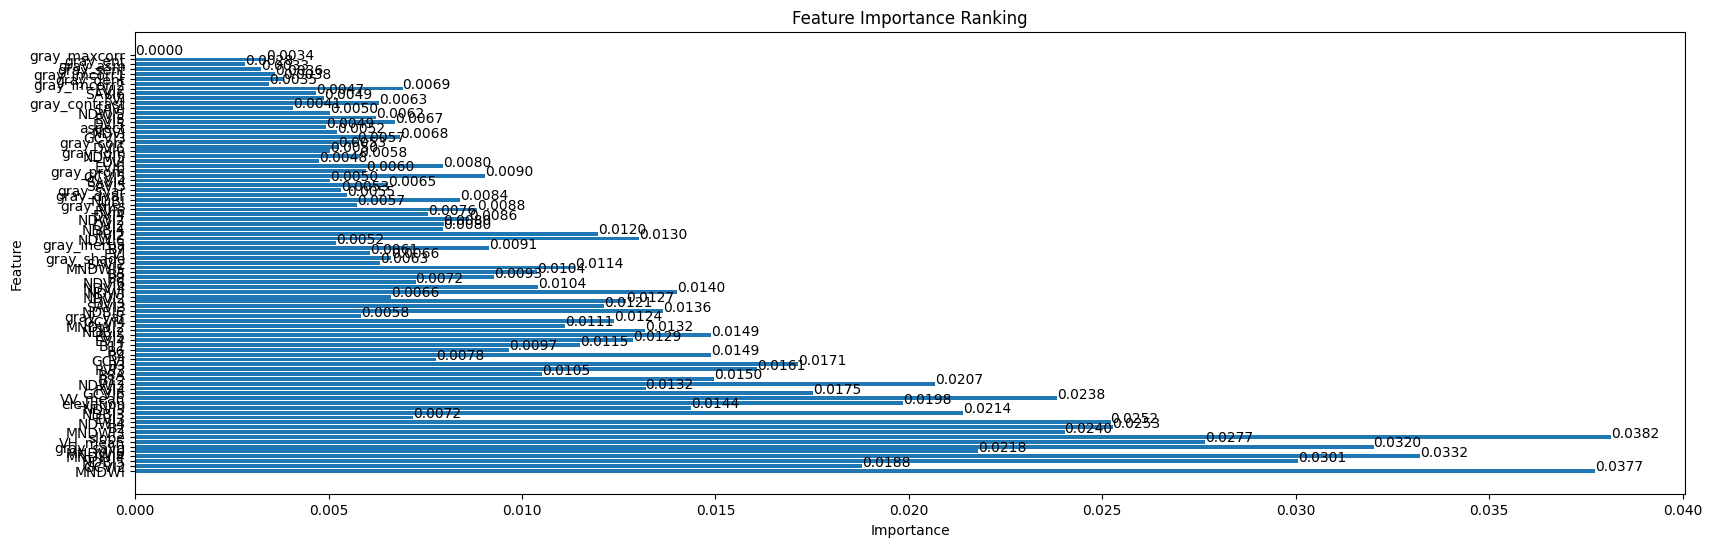

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE

# 假设data是包含特征和标签列的数据框
X = result1.iloc[:, :87]  # 假设前87列是特征
y = result1.iloc[:, -1]   # 假设最后一列是标签

# 使用随机森林算法计算特征的重要性
rfc = RandomForestClassifier()
rfc.fit(X, y)
feature_importances = rfc.feature_importances_

# 使用RFE算法对特征进行排序
rfe = RFE(estimator=rfc, n_features_to_select=1)
rfe.fit(X, y)
ranking = rfe.ranking_

# 合并特征的重要性和排序结果
feature_ranking = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances, 'Ranking': ranking})
feature_ranking = feature_ranking.sort_values(by='Ranking')

# 打印每个特征的重要性数值
for index, row in feature_ranking.iterrows():
    print(f"{row['Feature']}: {row['Importance']:.4f}")

# 绘制特征重要性图表
plt.figure(figsize=(20, 6))
plt.barh(feature_ranking['Feature'], feature_ranking['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance Ranking')

# 在图表中显示特征重要性数值
for index, value in enumerate(feature_ranking['Importance']):
    plt.text(value, index, f'{value:.4f}', ha='left')

plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# 保存特征重要性数据到CSV文件
result1.to_csv('/content/drive/My Drive/result1.csv', index=False)
# 保存特征重要性数据到CSV文件
feature_ranking.to_csv('/content/drive/My Drive/feature_ranking.csv', index=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
